In [13]:
import io
from scipy import misc
import glob
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import array_to_img
import cv2
from data import *


class myUnet(object):
    def __init__(self, img_rows=512, img_cols=512):
        self.img_rows = img_rows
        self.img_cols = img_cols

    def load_data(self):
        mydata = dataProcess(self.img_rows, self.img_cols)
        imgs_train, imgs_mask_train = mydata.load_train_data()
        imgs_test = mydata.load_test_data()
        return imgs_train, imgs_mask_train, imgs_test

    def get_unet(self):
        inputs = Input((self.img_rows, self.img_cols, 3))

        conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(drop5))
        merge6 = concatenate([drop4, up6], axis=3)
        conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

        up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(conv6))
        merge7 = concatenate([conv3, up7], axis=3)
        conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

        up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(conv7))
        merge8 = concatenate([conv2, up8], axis=3)
        conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

        up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
            UpSampling2D(size=(2, 2))(conv8))
        merge9 = concatenate([conv1, up9], axis=3)
        conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

        conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
        model = Model(input=inputs, output=conv10)

        model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

        return model

    def train(self):
       # print("loading data")
        imgs_train, imgs_mask_train, imgs_test = self.load_data()
        print(imgs_train.shape)
       # print("loading data done")
        model = self.get_unet()
       # print("got unet")
        model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', verbose=1, save_best_only=True)
       # print('Fitting model...')
        model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=2, verbose=1,
                  validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

        print('predict test data')
        imgs_mask_test = model.predict(imgs_test, batch_size=1, verbose=1)
        np.save('./results/imgs_mask_test.npy', imgs_mask_test)

    def save_img(self):
        print("array to image")
        imgs = np.load('./results/imgs_mask_test.npy')
        piclist = []
        for line in open("./results/pic.txt"):
            line = line.strip()
            picname = line.split('/')[-1]
            piclist.append(picname)
            
        for i in range(imgs.shape[0]):
            image=Image.open("./data/test/"+str(i)+".png")
            path = "./results/" + piclist[i]
            img = imgs[i]
            img = array_to_img(img)
            
            img.save(path)
            
            
            image = Image.open("./data/test/"+str(i)+".png")
            
            width, height = image.size[0],image.size[1]
            
            cv_pic = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            cv_pic = cv2.resize(cv_pic,(image.size[0],image.size[1]),interpolation=cv2.INTER_CUBIC)
            binary, cv_save = cv2.threshold(cv_pic, 70, 255, cv2.THRESH_BINARY)
            
            cv2.imwrite(path, cv_save)
            
           
            new_img = Image.new("RGB", (image.size[0], image.size[1]))
            
            rgb_im = image.convert('RGB')
            
                
            for x in range(image.size[0]):
                for y in range(image.size[1]):
                    r_old, g_old, b_old = rgb_im.getpixel((x, y))
                    if(cv_save[y][x]==255):
                        new_img.putpixel((x,y), (r_old, g_old, b_old))
                    else:
                        new_img.putpixel((x,y), (255, 255, 255))  
            new_img.save("./results/rgb/"+str(i)+".png")

if __name__ == '__main__':
    myunet = myUnet()
#     model = myunet.get_unet()
    # model.summary()
    # plot_model(model, to_file='model.png')
#     myunet.train()
    myunet.save_img()

array to image


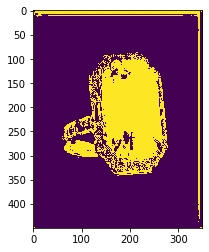

In [8]:
imgs = np.load('./results/imgs_mask_test.npy')
img = imgs[6]
img = array_to_img(img)
img.save("./results/kek.png")
cv_pic = cv2.imread("./results/kek.png", cv2.IMREAD_GRAYSCALE)
cv_pic = cv2.resize(cv_pic,(350,450),interpolation=cv2.INTER_CUBIC)
binary, cv_save = cv2.threshold(cv_pic, 70, 255, cv2.THRESH_BINARY)
cv2.imwrite("./results/kek.png", cv_save)
plt.imshow(cv_save)
#print(np.unique(cv_pic))